# Based on Riess et. al 2009a and Riess et. al 2016

In [1]:
import numpy as np
from numpy import power as pw
import matplotlib.pyplot as plt
from iminuit import Minuit
import matplotlib.gridspec as gridspec

## Riess et. al 2009

### Data load

In [2]:
dtypes_ceph = {'names': ('Field', 'RAdeg', 'DEdeg', 'Id', 'Per', 'F555W-F814W', 'F160W', 'sigma_tot','Offset','Bias','Phase','[O/H]','Flag','Src'),'formats': ('a5', 'f', 'f', 'i', 'f', 'f', 'f', 'f', 'f','f','f','f','a8','a5') }
data_cephe_R09 = np.loadtxt("/renoir/carreres/Documents/H0 measurement/Cepheids data/R09_cepheids.dat",dtype=dtypes_ceph)

dtypes_sn={'names': ('Field', 'SN', 'Filters', 'mag_5a', 'sigma_mag_5a', 'mu_i-mu4258', 'sigma_diff_mu'),'formats': ('a8', 'a8', 'a5', 'f', 'f', 'f', 'f') }
data_sn_R09=np.loadtxt("/renoir/carreres/Documents/H0 measurement/Cepheids data/R09_SN.txt",dtype=dtypes_sn)

sn_host=data_sn_R09['Field']

In [3]:
#Selection 2.7 sigma
s1 = data_cephe_R09['Flag'] == b'None'
s2 = data_cephe_R09['Flag'] == b'<P'
data_cephe_R09 = data_cephe_R09[s1+s2]


### b_H slope

In [4]:
#b_H, Zp4258
n_params = 2
n_sn = len(sn_host)
n_ceph_by_host = [len(data_cephe_R09[data_cephe_R09['Field']== host]) for host in sn_host]
n_ceph = np.sum(n_ceph_by_host)
n_ceph_cumsum = np.concatenate(([0],np.cumsum(n_ceph_by_host)))
L_ceph = np.zeros((n_ceph,n_sn+n_params))
y_ceph=np.zeros(n_ceph, dtype='f4')
cov_ceph=np.zeros(n_ceph)

for i,host in enumerate(sn_host):
    selec_ceph = data_cephe_R09[data_cephe_R09['Field'] == host]
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],i] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-2] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-1] = np.log10(selec_ceph['Per'])
    y_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = selec_ceph['F160W'] 
    
    cov_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = pw(selec_ceph['sigma_tot'],2)
    

selec_ceph = data_cephe_R09[[i not in sn_host for i in data_cephe_R09['Field']]]
n_4258 = len(selec_ceph)
L_4258 = np.zeros((n_4258,n_sn+n_params))
L_4258[:,-2] = 1
L_4258[:,-1] = np.log10(selec_ceph['Per']) 
y_4258 = selec_ceph['F160W'] 
cov_4258 = pw(selec_ceph['sigma_tot'],2)

In [5]:
L = np.concatenate((L_ceph,L_4258),axis=0)
y = np.concatenate((y_ceph,y_4258))
C = np.diag(np.concatenate((cov_ceph,cov_4258)))

#### Fisher solution

In [6]:
C_inv = np.linalg.inv(C)
cov_res = np.linalg.inv(L.T @ C_inv @ L)
res = cov_res @ L.T @ C_inv @ y

chi2 = ((y-L @ res).T @ C_inv @ (y-L @ res))/(np.size(y)-np.size(res))

In [7]:
print(f'b_h = {res[-1]} +/- {np.sqrt(cov_res[-1,-1])}')
print(f'chi2 = {chi2}')

b_h = -3.0352789600712042 +/- 0.0902991425375763
chi2 = 1.409876547806551


#### Minuit $\chi^2$ minimization

In [8]:
def chi2_bh(q):
    return (y-L @ q).T @ C_inv @ (y-L.dot(q))

In [9]:
x0 = [1.40404562,2.20035556,2.46433945,2.77387999,2.87413743,3.12362051,26.81027181,-3.09]
fix = [False, False, False, False, False, False, False, False]
names = np.concatenate((np.array(["mu_{}_muN4258".format(n.decode('utf-8')) for n in sn_host]),np.array(['zp_w4258','b_H'])))
chimin_bh = Minuit.from_array_func(chi2_bh,x0, errordef = 1,fix=fix ,error=0.001,name=names)

In [10]:
chimin_bh.migrad()
chimin_bh.hesse()
chimin_bh.minos()
print(chimin_bh.params)
print(f'chi2={chimin_bh.fval/(np.size(y)-np.size(res))}')

┌───┬──────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name             │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu_N4536_muN4258 │   1.40    │   0.07    │   -0.07    │    0.07    │         │         │       │
│ 1 │ mu_N4639_muN4258 │   2.20    │   0.08    │   -0.08    │    0.08    │         │         │       │
│ 2 │ mu_N3982_muN4258 │   2.46    │   0.08    │   -0.08    │    0.08    │         │         │       │
│ 3 │ mu_N3370_muN4258 │   2.77    │   0.07    │   -0.07    │    0.07    │         │         │       │
│ 4 │ mu_N3021_muN4258 │   2.87    │   0.09    │   -0.09    │    0.09    │         │         │       │
│ 5 │ mu_N1309_muN4258 │   3.12    │   0.07    │   -0.07    │    0.07    │         │         │       │
│ 6 │ zp_w4258         │   26.81   │   0.13    │   -0.13    │    0.13    

#### Fit results plot 

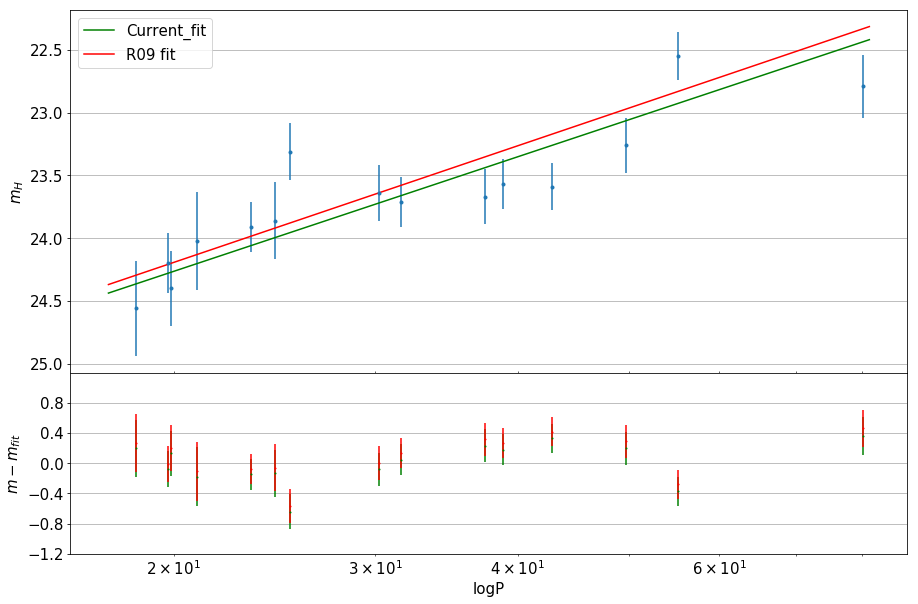

mean residual of current fit= 0.0006580353
mean residual of R09 fit= 0.08260842


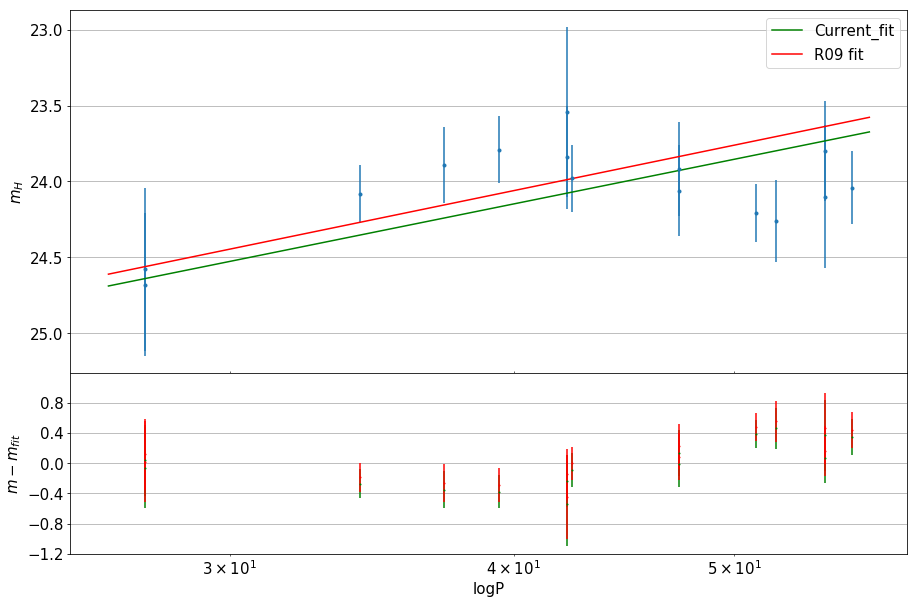

mean residual of current fit= -0.009117763
mean residual of R09 fit= 0.08012543


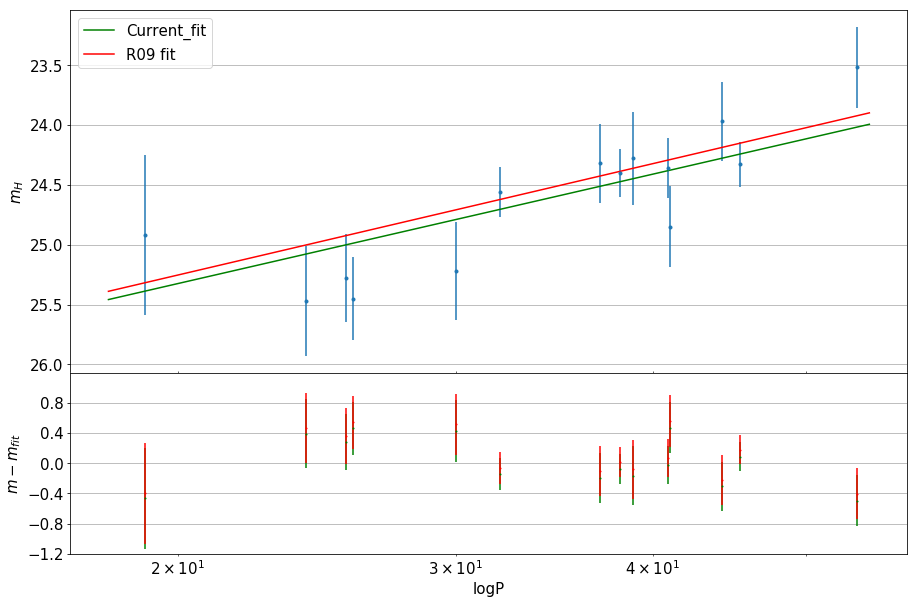

mean residual of current fit= 0.016652243
mean residual of R09 fit= 0.10054493


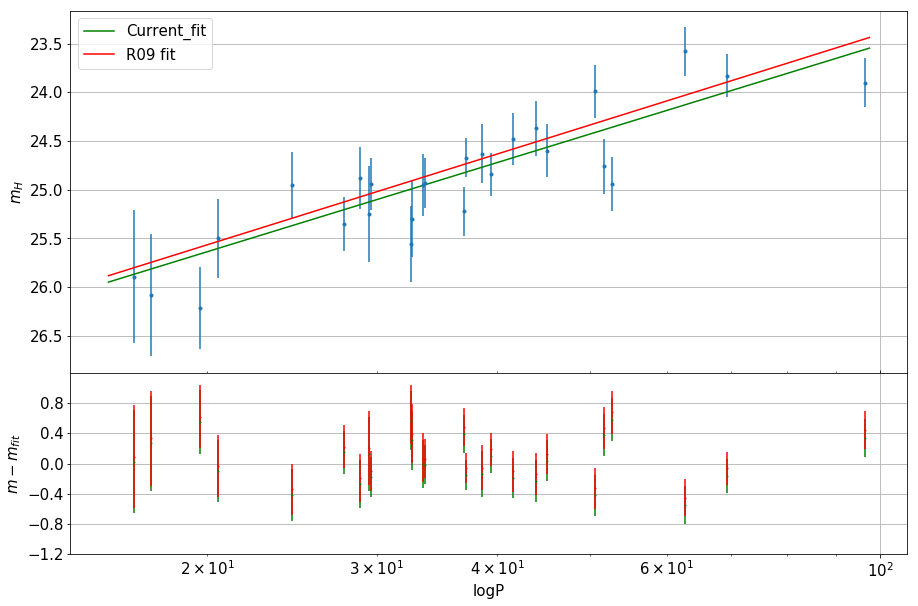

mean residual of current fit= 0.037436485
mean residual of R09 fit= 0.12242002


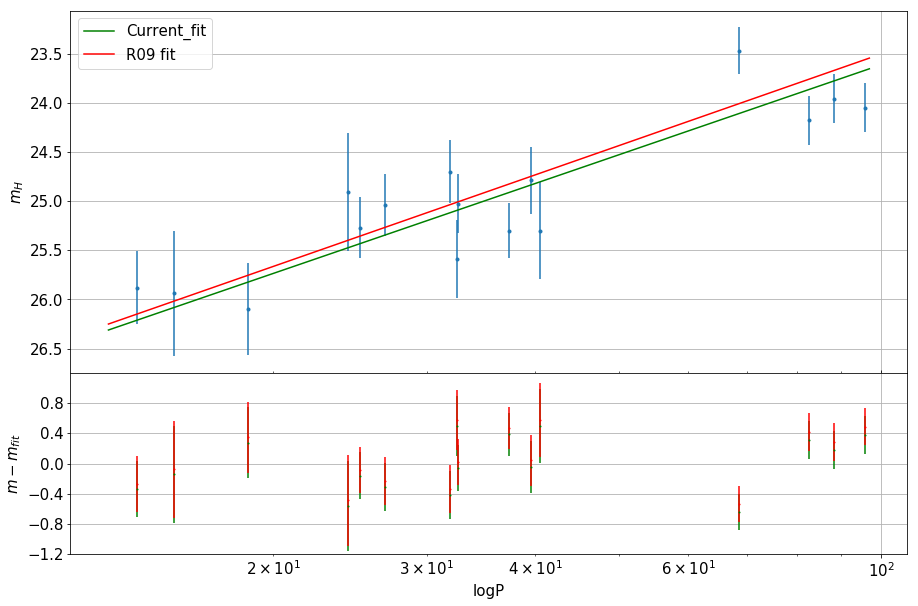

mean residual of current fit= -0.009420276
mean residual of R09 fit= 0.075413704


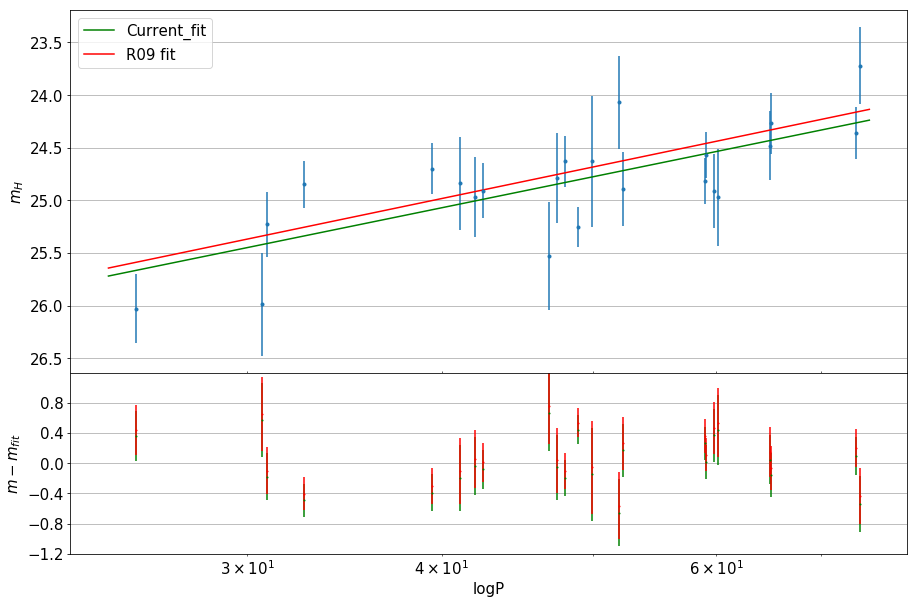

mean residual of current fit= 0.01308126
mean residual of R09 fit= 0.105080895


In [11]:
for i,host in enumerate(sn_host):
    cephe_list = data_cephe_R09[data_cephe_R09['Field']== host]
    p = np.linspace(np.min(cephe_list['Per'])-1,np.max(cephe_list['Per'])+1,1000)
    
    fig=plt.figure(figsize = (15, 10))
    plt.title(host)
    plt.rcParams.update({'font.size': 15})
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
    ax0 = plt.subplot(gs[0])
    ax0.set_xlabel('logP')
    ax0.set_ylabel('$m_H$')
    ax0.set_xscale('log')
    ax0.errorbar(cephe_list['Per'], cephe_list['F160W'],yerr=cephe_list['sigma_tot'],fmt='.')
    ax0.plot(p,res[i]+res[-2]+res[-1]*np.log10(p), color='g', label='Current_fit')
    ax0.plot(p,res[i]+res[-2]-3.09*np.log10(p), color='r', label='R09 fit')
    ax0.invert_yaxis()
    ax0.tick_params(axis='x',which='both', direction='in')
    ax0.grid()
    ax0.legend()
    ax1 = plt.subplot(gs[1],sharex=ax0)
    ax1.set_xlabel('logP')
    ax1.set_ylabel('$m-m_{fit}$')
    ax1.errorbar(cephe_list['Per'],cephe_list['F160W']-(res[i]+res[-2]+res[-1]*np.log10(cephe_list['Per'])),yerr=cephe_list['sigma_tot'],fmt ='.',elinewidth=1.5,ms=2,color='g')
    ax1.errorbar(cephe_list['Per'],cephe_list['F160W']-(res[i]+res[-2]-3.09*np.log10(cephe_list['Per'])),yerr=cephe_list['sigma_tot'],fmt ='.',elinewidth=1.5, ms=2, color='r')
    ax1.grid()
    ax1.set_ylim(-1.2,1.2)
    ax1.set_yticks(np.arange(-1.2,1.2,step=0.4))
    plt.subplots_adjust(hspace=.0)
    plt.setp(ax0.get_xticklabels(), visible=False)
    plt.show()
    print("mean residual of current fit=",np.mean(cephe_list['F160W']-(res[i]+res[-2]+res[-1]*np.log10(cephe_list['Per']))))
    print("mean residual of R09 fit=",np.mean(cephe_list['F160W']-(res[i]+res[-2]-3.09*np.log10(cephe_list['Per']))))


### b_w slope

In [12]:
R=0.479 #Cardelli et al. (1989) Rv=3.1 R=0.479

In [13]:
#b_w, Zp4258
n_params = 2
n_ceph_by_host = [len(data_cephe_R09[data_cephe_R09['Field']== host]) for host in sn_host]
n_ceph = np.sum(n_ceph_by_host)
n_ceph_cumsum = np.concatenate(([0],np.cumsum(n_ceph_by_host)))
L_ceph = np.zeros((n_ceph,n_sn+n_params))
y_ceph=np.zeros(n_ceph, dtype='f4')
cov_ceph=np.zeros(n_ceph)

for i,host in enumerate(sn_host):
    selec_ceph = data_cephe_R09[data_cephe_R09['Field'] == host]
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],i] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-2] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-1] = np.log10(selec_ceph['Per'])
     
    y_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
    
    cov_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = pw(selec_ceph['sigma_tot'],2)+pw(0.02*R,2)
    

selec_ceph = data_cephe_R09[[i not in sn_host for i in data_cephe_R09['Field']]]
n_4258 = len(selec_ceph)
L_4258 = np.zeros((n_4258,n_sn+n_params))
L_4258[:,-2] = 1
L_4258[:,-1] = np.log10(selec_ceph['Per'])

y_4258 = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
cov_4258 = pw(selec_ceph['sigma_tot'],2)+pw(0.02*R,2)

In [14]:
L = np.concatenate((L_ceph,L_4258),axis=0)
y = np.concatenate((y_ceph,y_4258))
C = np.diag(np.concatenate((cov_ceph,cov_4258)))

#### Fisher solution

In [15]:
C_inv = np.linalg.inv(C)
cov_res = np.linalg.inv(L.T @ C_inv @ L)
res = cov_res @ L.T @ C_inv @ y

chi2 = ((y-L @ res).T @ C_inv @ (y-L @ res))/(np.size(y)-np.size(res))

In [16]:
print(res)
print(np.sqrt(cov_res[-1,-1]))

[ 1.43369098  2.18213237  2.46304307  2.78423668  2.97241481  3.25951885
 26.5357946  -3.18137052]
0.09036546911265282


#### Minuit $\chi^2$ minimization

In [17]:
def chi2_bw(q):
    return (y-L @ q).T @ C_inv @ (y-L.dot(q))

In [18]:
x0 = [1.40404562,2.20035556,2.46433945,2.77387999,2.87413743,3.12362051,26.81027181,-3.20]
fix = [False, False, False, False, False, False, False, False]
names = np.concatenate((np.array(["mu_{}_muN4258".format(n.decode('utf-8')) for n in sn_host]),np.array(['zp_w4258','b_H'])))
chimin_bw = Minuit.from_array_func(chi2_bw,x0, errordef = 1,fix=fix ,error=0.001,name=names)

In [19]:
chimin_bw.migrad()
chimin_bw.hesse()
chimin_bw.minos()
print(chimin_bw.params)
print(f'chi2={chimin_bw.fval/(np.size(y)-np.size(res))}')

┌───┬──────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name             │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu_N4536_muN4258 │   1.43    │   0.07    │   -0.07    │    0.07    │         │         │       │
│ 1 │ mu_N4639_muN4258 │   2.18    │   0.08    │   -0.08    │    0.08    │         │         │       │
│ 2 │ mu_N3982_muN4258 │   2.46    │   0.08    │   -0.08    │    0.08    │         │         │       │
│ 3 │ mu_N3370_muN4258 │   2.78    │   0.07    │   -0.07    │    0.07    │         │         │       │
│ 4 │ mu_N3021_muN4258 │   2.97    │   0.09    │   -0.09    │    0.09    │         │         │       │
│ 5 │ mu_N1309_muN4258 │   3.26    │   0.07    │   -0.07    │    0.07    │         │         │       │
│ 6 │ zp_w4258         │   26.54   │   0.13    │   -0.13    │    0.13    

#### Fit result plot

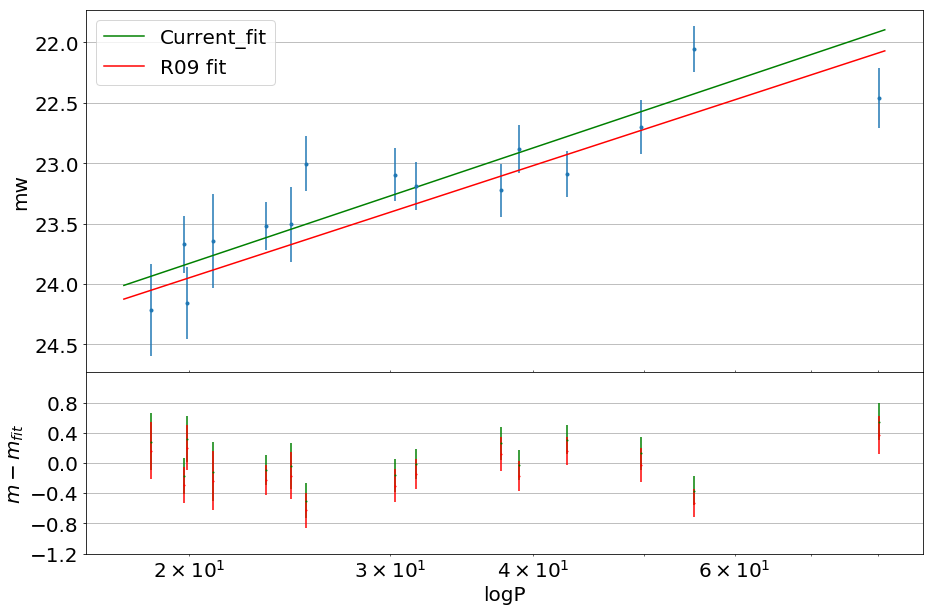

mean residual of current fit= 0.022318777
mean residual of R09 fit= -0.114517845


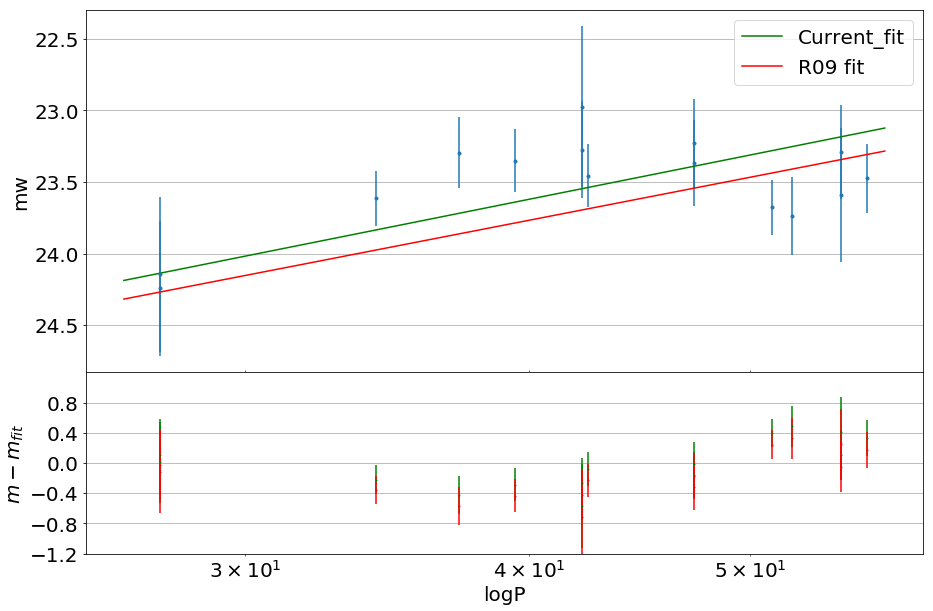

mean residual of current fit= -0.013680521
mean residual of R09 fit= -0.16269493


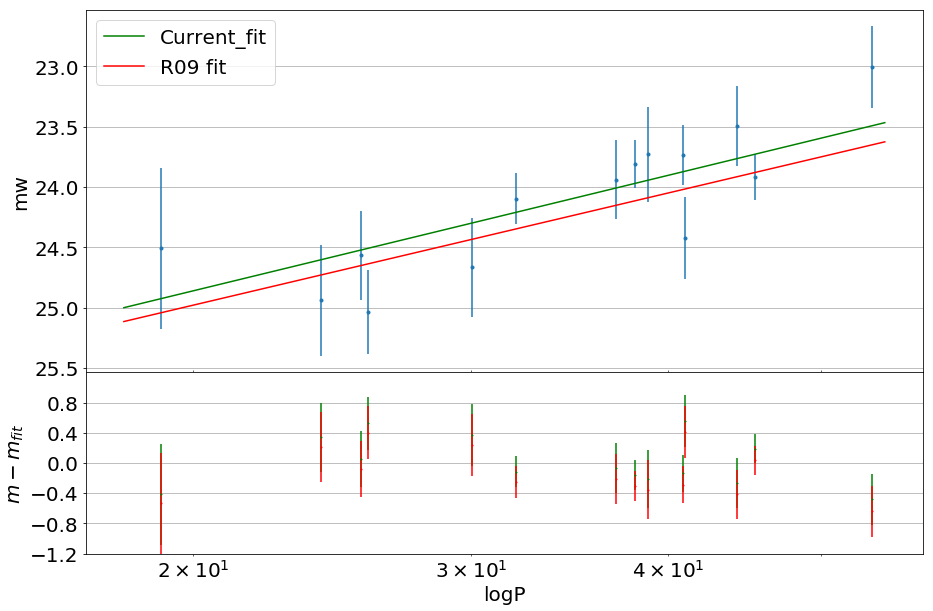

mean residual of current fit= 0.0110526765
mean residual of R09 fit= -0.12902805


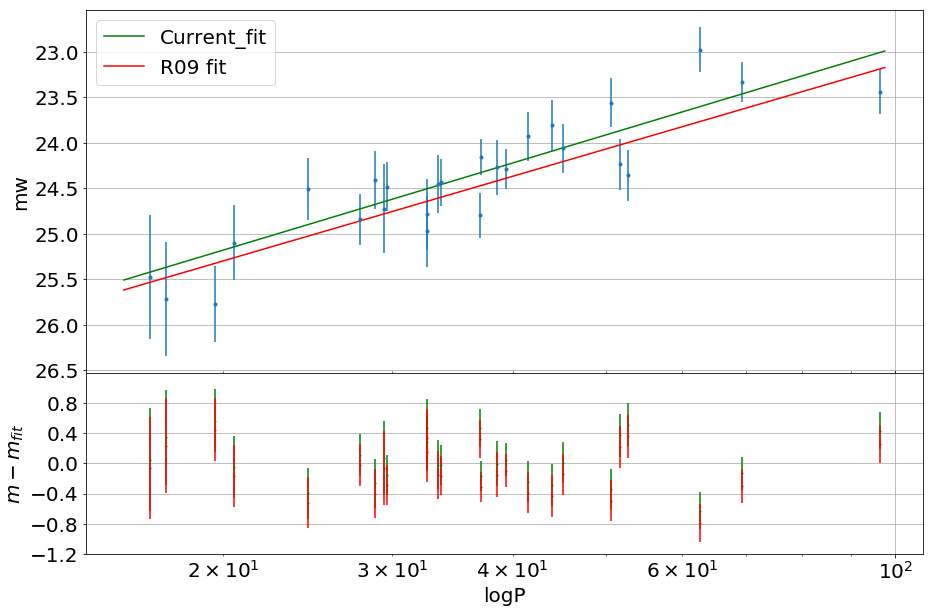

mean residual of current fit= 0.03967784
mean residual of R09 fit= -0.10222406


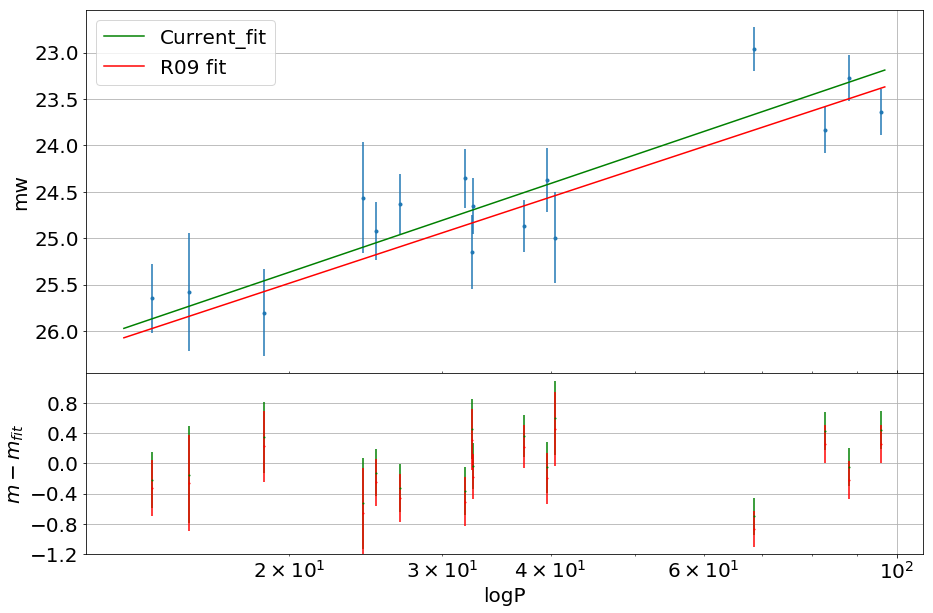

mean residual of current fit= 0.0037807226
mean residual of R09 fit= -0.13787198


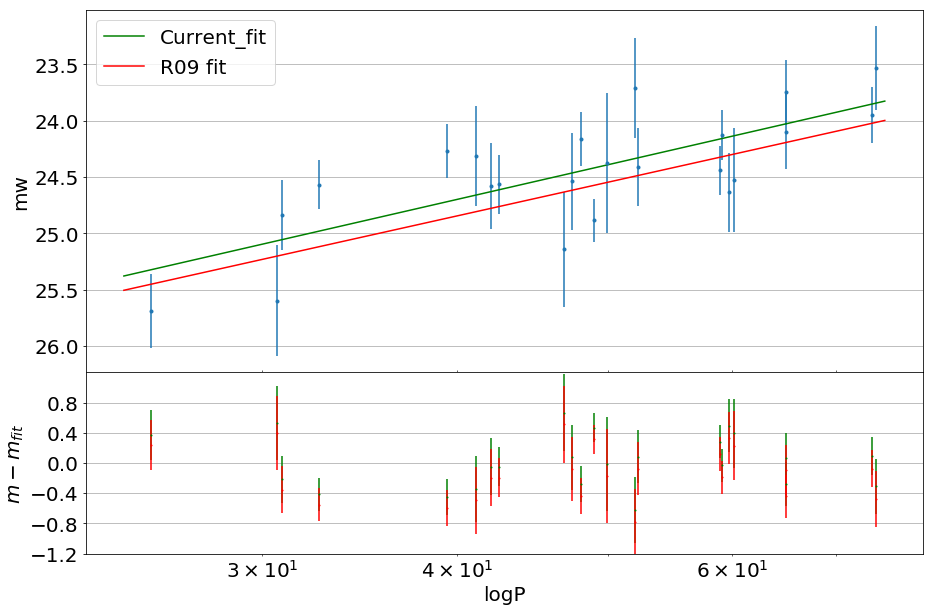

mean residual of current fit= 0.01886799
mean residual of R09 fit= -0.13474879


In [20]:
for i,host in enumerate(sn_host):
    cephe_list = data_cephe_R09[data_cephe_R09['Field']== host]
    p = np.linspace(np.min(cephe_list['Per'])-1,np.max(cephe_list['Per'])+1,1000)
    
    fig=plt.figure(figsize = (15, 10))
    plt.title(host)
    plt.rcParams.update({'font.size': 20})
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
    ax0 = plt.subplot(gs[0])
    ax0.set_xlabel('logP')
    ax0.set_ylabel('mw')
    ax0.set_xscale('log')
    ax0.errorbar(cephe_list['Per'], cephe_list['F160W']-R*cephe_list['F555W-F814W'],yerr=cephe_list['sigma_tot'],fmt='.')
    ax0.plot(p,res[i]+res[-2]+res[-1]*np.log10(p), color='g', label='Current_fit')
    ax0.plot(p,res[i]+res[-2]-3.09*np.log10(p), color='r', label='R09 fit')
    ax0.invert_yaxis()
    ax0.tick_params(axis='x',which='both', direction='in')
    ax0.grid()
    ax0.legend()
    ax1 = plt.subplot(gs[1],sharex=ax0)
    ax1.set_xlabel('logP')
    ax1.set_ylabel('$m-m_{fit}$')
    ax1.errorbar(cephe_list['Per'],cephe_list['F160W']-R*cephe_list['F555W-F814W']-(res[i]+res[-2]+res[-1]*np.log10(cephe_list['Per'])),yerr=cephe_list['sigma_tot'],fmt ='.',elinewidth=1.5,ms=2,color='g')
    ax1.errorbar(cephe_list['Per'],cephe_list['F160W']-R*cephe_list['F555W-F814W']-(res[i]+res[-2]-3.09*np.log10(cephe_list['Per'])),yerr=cephe_list['sigma_tot'],fmt ='.',elinewidth=1.5, ms=2, color='r')
    ax1.grid()
    ax1.set_ylim(-1.2,1.2)
    ax1.set_yticks(np.arange(-1.2,1.2,step=0.4))
    plt.subplots_adjust(hspace=.0)
    plt.setp(ax0.get_xticklabels(), visible=False)
    plt.show()
    print("mean residual of current fit=",np.mean(cephe_list['F160W']-R*cephe_list['F555W-F814W']-(res[i]+res[-2]+res[-1]*np.log10(cephe_list['Per']))))
    print("mean residual of R09 fit=",np.mean(cephe_list['F160W']-R*cephe_list['F555W-F814W']-(res[i]+res[-2]-3.09*np.log10(cephe_list['Per']))))


### H0 fit

In [21]:
R=0.479 #Cardelli et al. (1989) Rv=3.1 R=0.479

av=0.698 #240 SNe Ia from Hicken et al. (2009)
sigma_av=0.00225

mu_N4258 = 5*np.log10(7.28)+25
sigma_mu_N4258 = 5/(np.log(10)*mu_N4258)*3/100*7.28
#sigma_mu_N4258 = 5/(np.log(10)*mu_N4258)*np.sqrt(0.5**2+0.2**2)

In [22]:
#res = mu_i-mu_4258, zpw4258, bw, m_4258, Zw
n_params = 3

n_ceph_by_host = [len(data_cephe_R09[data_cephe_R09['Field']== host]) for host in sn_host]
n_ceph = np.sum(n_ceph_by_host)
n_ceph_cumsum = np.concatenate(([0],np.cumsum(n_ceph_by_host)))
n_sn = len(sn_host)
L_ceph = np.zeros((n_ceph,n_sn+n_params))
L_sn = np.zeros((n_sn,n_sn+n_params))
y_ceph=np.zeros(n_ceph)
y_sn = np.zeros(n_sn)
cov_ceph=np.zeros(n_ceph)
cov_sn=np.zeros(n_sn)

for i,host in enumerate(sn_host):
    selec_ceph = data_cephe_R09[data_cephe_R09['Field'] == host]
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],i] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-4+1] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-3+1] = np.log10(selec_ceph['Per'])
    #L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-1] = selec_ceph['[O/H]'] - 8.9
 
    L_sn[i,i] = 1
    L_sn[i,-2+1] = 1
    
    y_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
    y_sn[i] = data_sn_R09[data_sn_R09['Field'] == host]['mag_5a'] - 5*av
    
    cov_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = pw(selec_ceph['sigma_tot'],2)
    cov_sn[i] = pw(data_sn_R09[data_sn_R09['Field'] == host]['sigma_mag_5a'],2)-25*pw(sigma_av,2)
    
selec_ceph = data_cephe_R09[[i not in sn_host for i in data_cephe_R09['Field']]]
n_4258 = len(selec_ceph)
L_4258 = np.zeros((n_4258,n_sn+n_params))
L_4258[:,-4+1] = 1
L_4258[:,-3+1] = np.log10(selec_ceph['Per'])
#L_4258[:,-1+1] = selec_ceph['[O/H]'] - 8.9

y_4258 = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
cov_4258 = pw(selec_ceph['sigma_tot'],2)

In [23]:
L = np.concatenate((L_ceph,L_4258,L_sn),axis=0)
y = np.concatenate((y_ceph,y_4258,y_sn))
C = np.diag(np.concatenate((cov_ceph,cov_4258,cov_sn)))
np.savetxt('L.txt', L, fmt='%1.2f')


In [24]:
C_inv = np.linalg.inv(C)
cov_res = np.linalg.inv(L.T @ C_inv @ L)
res = cov_res @ L.T @ C_inv @ y

chi2 = ((y-L @ res).T @ C_inv @ (y-L @ res))/(np.size(y)-np.size(res))


In [25]:
print(res)
print(chi2)

[ 1.43812754  2.23619737  2.3858866   2.80871511  2.99325838  3.22030804
 26.53711536 -3.18227156 10.20213489]
1.4847898259540777


In [26]:
log_H0 = (res[-1]-mu_N4258+5*av+25)/5
sigma_log_H0 = np.sqrt(25*pw(sigma_av,2)+pw(sigma_mu_N4258,2)+cov_res[-2,-2])/5  
H0 = pw(10,log_H0)
sigma_H0 = np.log(10)*pw(10,log_H0)*sigma_log_H0
print(f"logH0 = {log_H0} +/- {sigma_log_H0}")
print(f"H0 = {H0} +/- {sigma_H0}")

logH0 = 1.8762955992122545 +/- 0.018423675408894273
H0 = 75.21346545264933 +/- 3.1907116751863085


## Riess et al. 2016

### Data load and visualisation

In [27]:
dtypes={'names': ('Field', 'RAdeg', 'DEdeg', 'Id', 'Per', 'F555W-F814W', 'F160W', 'sigma_tot','[O/H]'),'formats': ('a5', 'f', 'f', 'a8', 'f', 'f', 'f', 'f', 'f') }

data_cephe=np.loadtxt("/renoir/carreres/Documents/H0 measurement/Cepheids data/R16_cepheids.txt",skiprows=22,dtype=dtypes)

dtypes={'names': ('Field', 'SN', 'mag_5a', 'sigma_mag_5a', 'approx_mu_ceph', 'sigma_mu', 'M0', 'sigma_M0'),'formats': ('a5', 'a5', 'f', 'f', 'f', 'f', 'f', 'f', 'f') }
data_sn=np.loadtxt("/renoir/carreres/Documents/H0 measurement/Cepheids data/R16_SN.txt",dtype=dtypes)

In [28]:
host_list = np.array([b'M101', b'N1015', b'N1309', b'N1365', 
                      b'N1448',b'N2442', b'N3021', 
                      b'N3370', b'N3447', b'N3972', 
                      b'N3982', b'N4038', b'N4258', 
                      b'N4424', b'N4536', b'N4639', 
                      b'N5584', b'N5917', b'N7250', b'U9391', b'M31'])

sn_host=[b'M101', b'N1015', b'N1309', b'N1365', 
                      b'N1448',b'N2442', b'N3021', 
                      b'N3370', b'N3447', b'N3972', 
                      b'N3982', b'N4038', b'N4424', 
                      b'N4536', b'N4639', b'N5584', 
                      b'N5917', b'N7250', b'U9391']



In [29]:
#DEFINITION DES MESURES EXTERNES
R=0.39

av=0.71273
sigma_av=0.00176

mu_N4258 = 29.387
sigma_mu_N4258 = 0.0568

#### Plot

/softdec/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


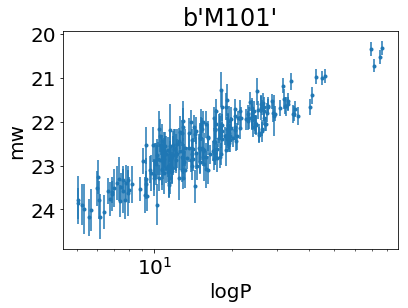

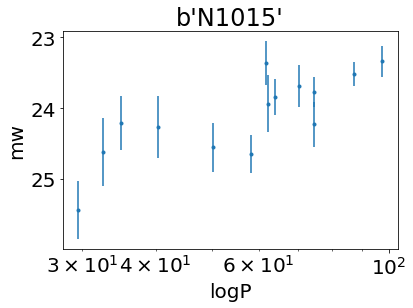

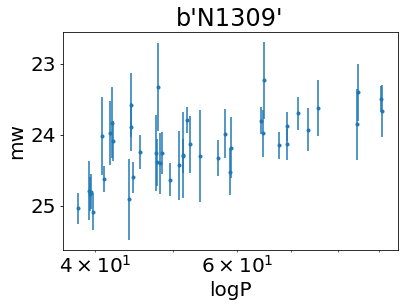

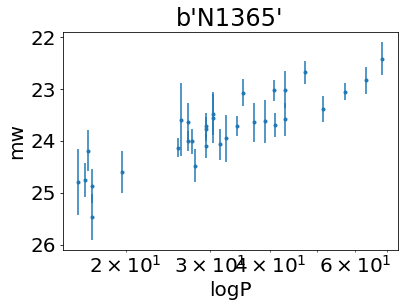

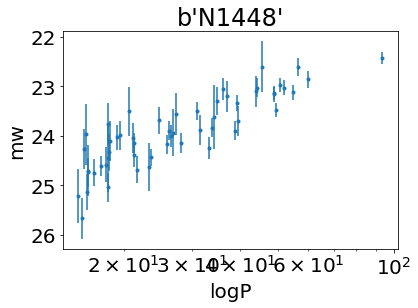

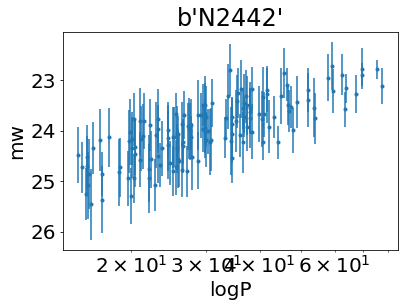

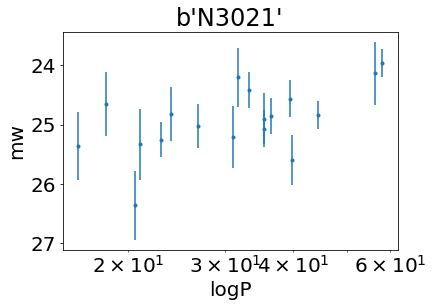

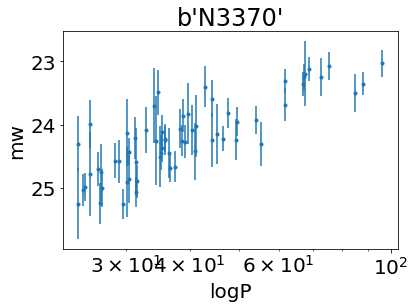

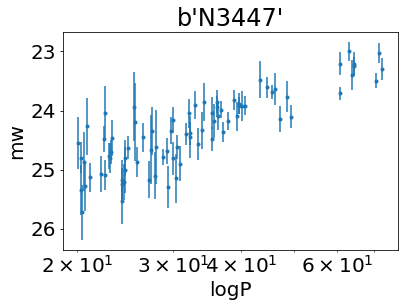

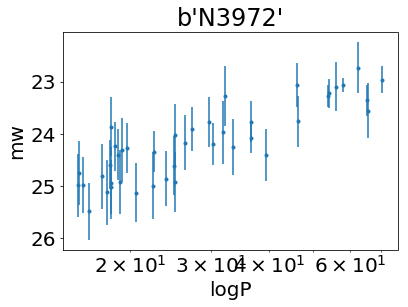

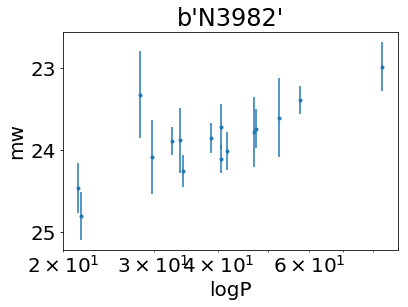

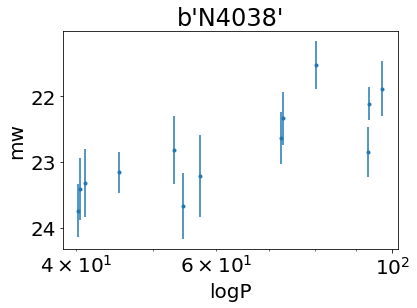

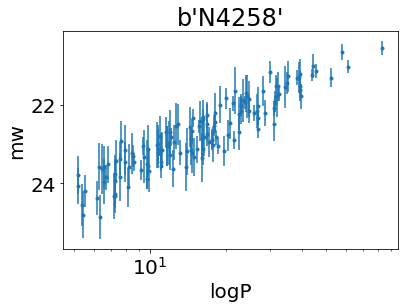

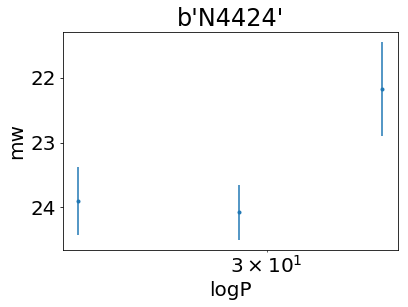

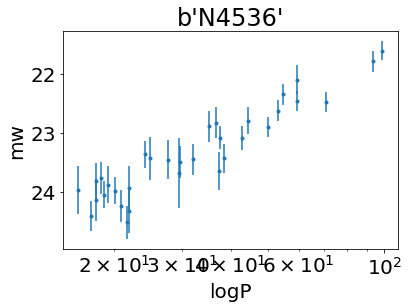

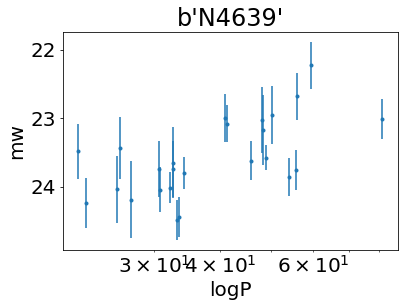

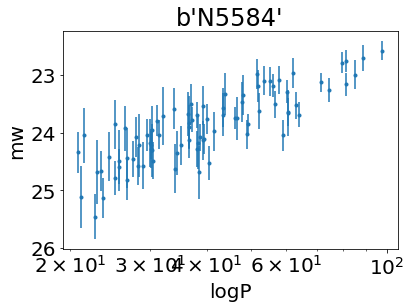

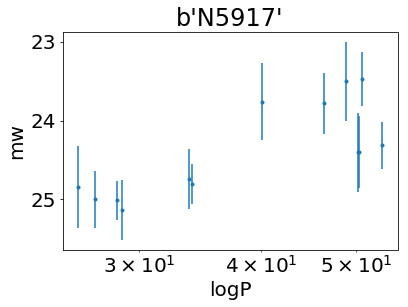

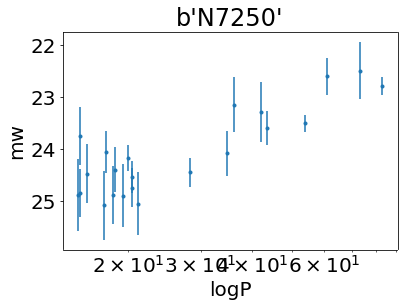

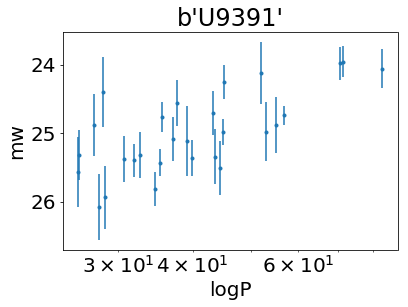

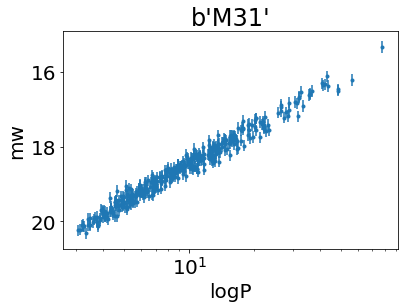

In [30]:
for host in host_list:
    cephe_list = data_cephe[data_cephe['Field']== host]
    plt.figure()
    plt.title(host)
    plt.errorbar(cephe_list['Per'], cephe_list['F160W']-R*cephe_list['F555W-F814W'],yerr=cephe_list['sigma_tot'],fmt='.')
    plt.gca().invert_yaxis()
    plt.xscale('log')
    plt.xlabel('logP')
    plt.ylabel('mw')
plt.show()

### Fit with one anchor : NGC 4258 

#### Simple slop

In [100]:
#res = mu_i-mu_4258, mu_M31-mu_4258, zpw4258, bw, Zw, m_4258
n_params = 5

############################
#SN HOST CEPHEIDS and SN Ia#
############################
n_ceph_by_host = [len(data_cephe[data_cephe['Field']== host]) for host in sn_host]
n_ceph = np.sum(n_ceph_by_host)
n_ceph_cumsum = np.concatenate(([0],np.cumsum(n_ceph_by_host)))
n_sn = len(sn_host)
L_ceph = np.zeros((n_ceph,n_sn+n_params))
L_sn = np.zeros((n_sn,n_sn+n_params))
y_ceph=np.zeros(n_ceph)
y_sn = np.zeros(n_sn)
cov_ceph=np.zeros(n_ceph)
cov_sn=np.zeros(n_sn)

for i,host in enumerate(sn_host):
    selec_ceph = data_cephe[data_cephe['Field']== host]
    
    n_ceph_host = n_ceph_by_host[i]
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],i] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-4] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-3] = np.log10(selec_ceph['Per'])
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-2] = selec_ceph['[O/H]'] - 8.9
    
    L_sn[i,i] = 1 
    L_sn[i,-1] = 1
    
    y_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]]= selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
    y_sn[i] = data_sn[data_sn['Field'] == host]['mag_5a'] - 5*av
    
    cov_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = pw(selec_ceph['sigma_tot'],2)
    cov_sn[i] = pw(data_sn[data_sn['Field']==host]['sigma_mag_5a'],2) #- 25*pw(sigma_av,2)

###################
#NGC 4258 CEPHEIDS#
###################
selec_ceph = data_cephe[data_cephe['Field']== b'N4258']
n_4258 = len(data_cephe[data_cephe['Field']== b'N4258'])
L_4258 = np.zeros((n_4258,n_sn+n_params))
L_4258[:,-4] = 1
L_4258[:,-3] = np.log10(selec_ceph['Per'])
L_4258[:,-2] = selec_ceph['[O/H]'] - 8.9

y_4258 = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
cov_4258 = pw(selec_ceph['sigma_tot'],2)

##############
#M31 CEPHEIDS#
##############
selec_ceph = data_cephe[data_cephe['Field'] == b'M31']
n_M31 = len(selec_ceph)
L_M31 = np.zeros((n_M31,n_sn+n_params))
L_M31[:,-5] = 1
L_M31[:,-4] = 1
L_M31[:,-3] = np.log10(selec_ceph['Per'])
L_M31[:,-2] = selec_ceph['[O/H]'] - 8.9
y_M31 = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
cov_M31 = pw(selec_ceph['sigma_tot'],2)

In [118]:
L = np.concatenate((L_ceph, L_4258, L_M31, L_sn))
y = np.concatenate((y_ceph, y_4258, y_M31, y_sn))
C = np.diag(np.concatenate((cov_ceph, cov_4258, cov_M31, cov_sn)))


##### Fisher solution

In [119]:
C_inv = np.linalg.inv(C)
cov_res = np.linalg.inv(L.T @ C_inv @ L)
res = cov_res @ L.T @ C_inv @ y

In [120]:
print(res)

[-0.18205148  3.21724966  3.17912279  1.9572586   1.99053487  2.18712541
  3.07264253  2.74580106  2.57802477  2.29965454  2.34774255  2.05440261
  1.50244464  1.57125506  2.2370921   2.45644494  2.92811265  2.1766741
  3.54992667 -4.88934538 26.59986985 -3.22895098 -0.16799982 10.07909712]


In [121]:
log_H0 = (res[-1]-mu_N4258+5*av+25)/5
sigma_log_H0 = np.sqrt(25*pw(sigma_av,2)+pw(sigma_mu_N4258,2)+cov_res[-1,-1])/5
H0 = pw(10,log_H0)
sigma_H0 = np.log(10)*pw(10,log_H0)*sigma_log_H0
print(f"logH0 = {log_H0} +/- {sigma_log_H0}")
print(f"H0 = {H0} +/- {sigma_H0}")

logH0 = 1.851149424481323 +/- 0.014140645339547545
H0 = 70.98219491276238 +/- 2.311183046317433


##### Minuit $\chi^2$ minimization

In [89]:
def chi2_simp(q):
    return (y-L @ q).T @ C_inv @ (y-L.dot(q))

In [90]:
names = np.concatenate((np.array(["mu_{}_muN4258".format(n.decode('utf-8')) for n in sn_host]),np.array(['mu_M31-mu_4248', 'zpw4258', 'bw', 'Zw', 'm_4258'])))
chimin_simp = Minuit.from_array_func(chi2_simp, res, errordef = 1, error=0.001, name=names)

In [91]:
chimin_simp.migrad()
chimin_simp.hesse()
chimin_simp.minos()
print(chimin_simp.params)
print(f'chi2={chimin_doub.fval/(np.size(y)-np.size(res))}')

┌───┬──────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name             │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu_M101_muN4258  │   -0.18   │   0.04    │   -0.04    │    0.04    │         │         │       │
│ 1 │ mu_N1015_muN4258 │   3.22    │   0.07    │   -0.07    │    0.07    │         │         │       │
│ 2 │ mu_N1309_muN4258 │   3.18    │   0.05    │   -0.05    │    0.05    │         │         │       │
│ 3 │ mu_N1365_muN4258 │   1.96    │   0.05    │   -0.05    │    0.05    │         │         │       │
│ 4 │ mu_N1448_muN4258 │   1.99    │   0.04    │   -0.04    │    0.04    │         │         │       │
│ 5 │ mu_N2442_muN4258 │   2.19    │   0.05    │   -0.05    │    0.05    │         │         │       │
│ 6 │ mu_N3021_muN4258 │   3.07    │   0.08    │   -0.08    │    0.08    

In [93]:
log_H0 = (chimin_simp.np_values()[-1]-mu_N4258+5*av+25)/5
sigma_log_H0 = np.sqrt(25*pw(sigma_av,2)+pw(sigma_mu_N4258,2)+cov_res[-2,-2])/5
H0 = pw(10,log_H0)
sigma_H0 = np.log(10)*pw(10,log_H0)*sigma_log_H0
print(f"logH0 = {log_H0} +/- {sigma_log_H0}")
print(f"H0 = {H0} +/- {sigma_H0}")

logH0 = 1.8511501384125395 +/- 0.01887080162004937
H0 = 70.98231159959248 +/- 3.0842968919573774


##### Fit results plot

In [ ]:
mu_mu4258_fit = chimin_simp.np_values()[:len(sn_host)]
zp = chimin_simp.np_values()[len(sn_host)]
bw = chimin_simp.np_values()[len(sn_host)+1]
zw = chimin_simp.np_values()[len(sn_host)+3]
for host,i in zip(sn_host,np.arange(len(sn_host))):
    cephe_list = data_cephe[data_cephe['Field']== host]
    plt.figure()
    plt.title(host)
    plt.errorbar(cephe_list['Per'], cephe_list['F160W']-R*cephe_list['F555W-F814W'],yerr=cephe_list['sigma_tot'],fmt='.')
    p = np.linspace(np.min(cephe_list['Per'])-1,np.max(cephe_list['Per'])+1,1000)
    plt.plot(p,mu_mu4258_fit[i]+zp+bw*np.log10(p)+zw*np.mean(cephe_list['[O/H]']-12))
    plt.gca().invert_yaxis()
    plt.xscale('log')
    plt.xlabel('logP')
    plt.ylabel('mw')
plt.show()

#### Double slop

In [66]:
#res = mu_i-mu_4258, mu_M31-mu_4258, zpw4258, bw, bl, Zw, m_4258
n_params = 6

############################
#SN HOST CEPHEIDS and SN Ia#
############################
n_ceph_by_host = [len(data_cephe[data_cephe['Field']== host]) for host in sn_host]
n_ceph = np.sum(n_ceph_by_host)
n_ceph_cumsum = np.concatenate(([0],np.cumsum(n_ceph_by_host)))
n_sn = len(sn_host)
L_ceph = np.zeros((n_ceph,n_sn+n_params))
L_sn = np.zeros((n_sn,n_sn+n_params))
y_ceph=np.zeros(n_ceph)
y_sn = np.zeros(n_sn)
cov_ceph=np.zeros(n_ceph)
cov_sn=np.zeros(n_sn)

for i,host in enumerate(sn_host):
    selec_ceph = data_cephe[data_cephe['Field'] == host]
    P_sup10 = selec_ceph['Per'] > 10
    P_inf10 = [not bool for bool in P_sup10]
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],i] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-5] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-4] = np.log10(selec_ceph['Per'])*P_sup10
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-3] = np.log10(selec_ceph['Per'])*P_inf10
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-2] = selec_ceph['[O/H]'] - 8.9
 
    L_sn[i,i] = 1
    L_sn[i,-1] = 1
    
    y_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
    y_sn[i] = data_sn[data_sn['Field'] == host]['mag_5a'] - 5*av
    
    cov_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = pw(selec_ceph['sigma_tot'],2)
    cov_sn[i] = pw(data_sn[data_sn['Field'] == host]['sigma_mag_5a'],2) - 25*pw(sigma_av,2)

###################
#NGC 4258 CEPHEIDS#
###################
selec_ceph = data_cephe[data_cephe['Field'] == b'N4258']
n_4258 = len(selec_ceph)
L_4258 = np.zeros((n_4258,n_sn+n_params))
P_sup10 = selec_ceph['Per'] > 10
P_inf10 = [not bool for bool in P_sup10]
L_4258[:,-5] = 1
L_4258[:,-4] = np.log10(selec_ceph['Per'])*P_sup10
L_4258[:,-3] = np.log10(selec_ceph['Per'])*P_inf10
L_4258[:,-2] = selec_ceph['[O/H]'] - 8.9

y_4258 = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
cov_4258 = pw(selec_ceph['sigma_tot'],2)
  
##############
#M31 CEPHEIDS#
##############
selec_ceph = data_cephe[data_cephe['Field'] == b'M31']
n_M31 = len(selec_ceph)
L_M31 = np.zeros((n_M31,n_sn+n_params))
P_sup10 = selec_ceph['Per'] > 10
P_inf10 = [not bool for bool in P_sup10]
L_M31[:,-6] = 1
L_M31[:,-5] = 1
L_M31[:,-4] = np.log10(selec_ceph['Per'])*P_sup10
L_M31[:,-3] = np.log10(selec_ceph['Per'])*P_inf10
L_M31[:,-2] = selec_ceph['[O/H]'] - 8.9

y_M31 = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
cov_M31 = pw(selec_ceph['sigma_tot'],2)



In [67]:
L = np.concatenate((L_ceph, L_4258, L_M31, L_sn))
y = np.concatenate((y_ceph, y_4258, y_M31, y_sn))
C = np.diag(np.concatenate((cov_ceph, cov_4258, cov_M31,cov_sn)))

##### Fisher solution

In [68]:
C_inv = np.linalg.inv(C)
cov_res = np.linalg.inv(L.T @ C_inv @ L)
res = cov_res @ L.T @ C_inv @ y

chi2 = ((y-L @ res).T @ C_inv @ (y-L @ res))/(np.size(y)-np.size(res))

In [69]:
print(res)
print(f'chi2 = {chi2}')

[-0.18246332  3.21863263  3.18005997  1.95744888  1.99092157  2.18738196
  3.07260448  2.74647802  2.57845687  2.30021181  2.34798259  2.05564578
  1.50266135  1.5717366   2.23774634  2.45727901  2.92855114  2.17715844
  3.55038767 -4.8892266  26.60594592 -3.23305296 -3.23819515 -0.1679452
 10.07859758]
chi2 = 1.0754925401500648


In [70]:
log_H0 = (res[-1]-mu_N4258+5*av+25)/5
sigma_log_H0 = np.sqrt(25*pw(sigma_av,2)+pw(sigma_mu_N4258,2)+cov_res[-1,-1])/5
H0 = pw(10,log_H0)
sigma_H0 = np.log(10)*pw(10,log_H0)*sigma_log_H0
print(f"logH0 = {log_H0} +/- {sigma_log_H0}")
print(f"H0 = {H0} +/- {sigma_H0}")

logH0 = 1.8510495150411443 +/- 0.01414207566298635
H0 = 70.96586733785377 +/- 2.3108851417664424


##### Minuit $\chi^2$ minimization

In [76]:
def chi2_doub(q):
    return (y-L @ q).T @ C_inv @ (y-L.dot(q))

In [77]:
names = np.concatenate((np.array(["mu_{}_muN4258".format(n.decode('utf-8')) for n in sn_host]),np.array(['mu_M31-mu_4248', 'zpw4258', 'bw', 'bl', 'Zw', 'm_4258'])))
chimin_doub = Minuit.from_array_func(chi2_simp, res, errordef = 1, error=0.001, name=names)

In [78]:
chimin_doub.migrad()
chimin_doub.hesse()
chimin_doub.minos()
print(chimin_doub.params)
print(f'chi2={chimin_doub.fval/(np.size(y)-np.size(res))}')

┌───┬──────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name             │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu_M101_muN4258  │   -0.18   │   0.04    │   -0.04    │    0.04    │         │         │       │
│ 1 │ mu_N1015_muN4258 │   3.22    │   0.07    │   -0.07    │    0.07    │         │         │       │
│ 2 │ mu_N1309_muN4258 │   3.18    │   0.05    │   -0.05    │    0.05    │         │         │       │
│ 3 │ mu_N1365_muN4258 │   1.96    │   0.05    │   -0.05    │    0.05    │         │         │       │
│ 4 │ mu_N1448_muN4258 │   1.99    │   0.04    │   -0.04    │    0.04    │         │         │       │
│ 5 │ mu_N2442_muN4258 │   2.19    │   0.05    │   -0.05    │    0.05    │         │         │       │
│ 6 │ mu_N3021_muN4258 │   3.07    │   0.08    │   -0.08    │    0.08    

In [79]:
log_H0 = (chimin_doub.np_values()[-1]-mu_N4258+5*av+25)/5
sigma_log_H0 = np.sqrt(25*pw(sigma_av,2)+pw(sigma_mu_N4258,2)+cov_res[-2,-2])/5
H0 = pw(10,log_H0)
sigma_H0 = np.log(10)*pw(10,log_H0)*sigma_log_H0
print(f"logH0 = {log_H0} +/- {sigma_log_H0}")
print(f"H0 = {H0} +/- {sigma_H0}")

logH0 = 1.8510495150411443 +/- 0.01887082159974884
H0 = 70.96586733785377 +/- 3.083585626819944


#### Fit results plot

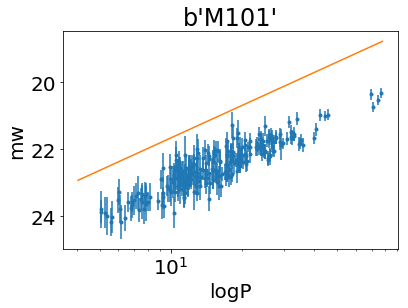

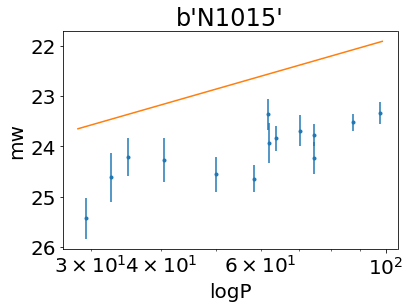

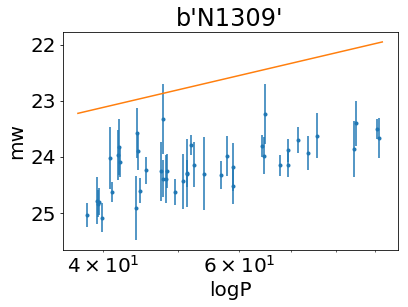

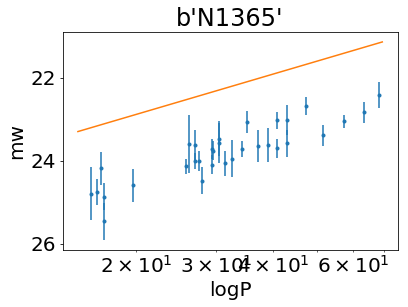

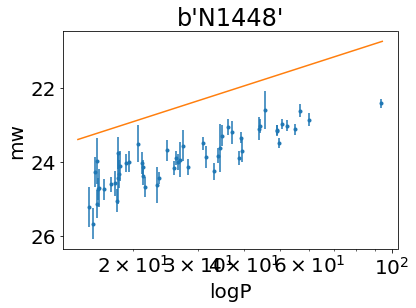

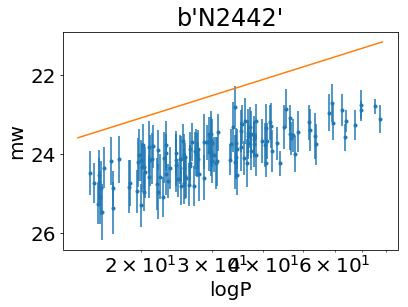

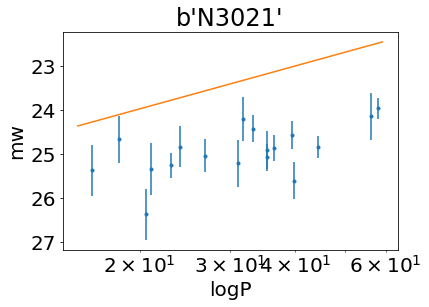

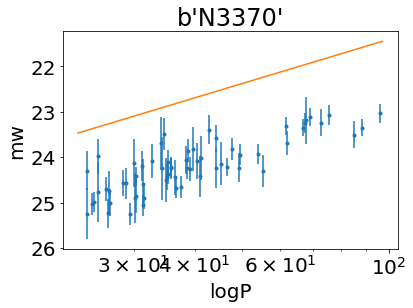

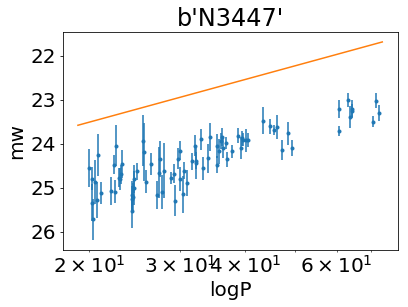

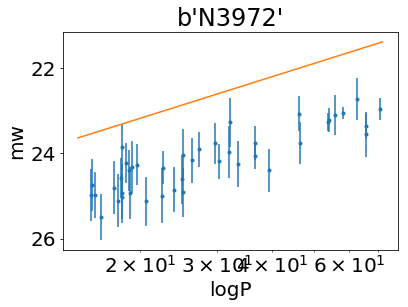

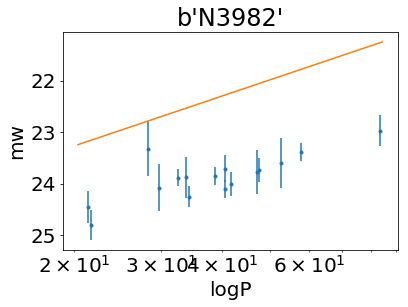

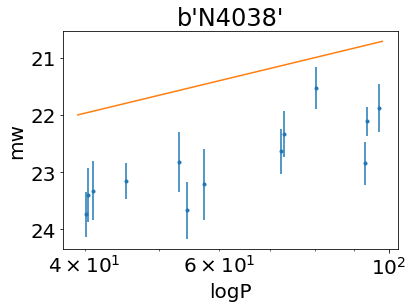

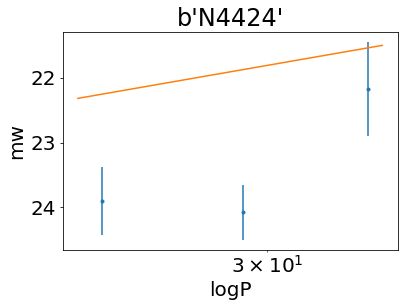

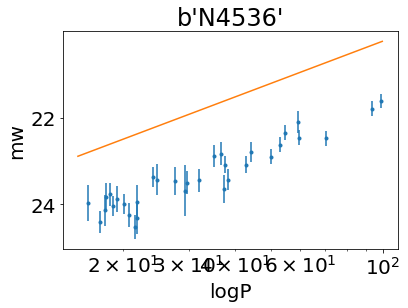

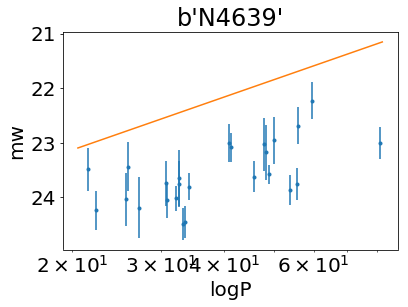

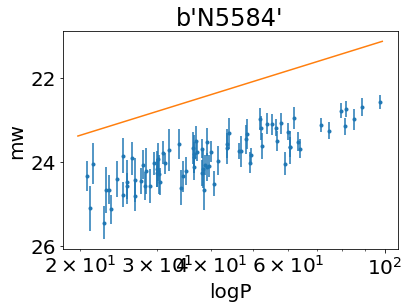

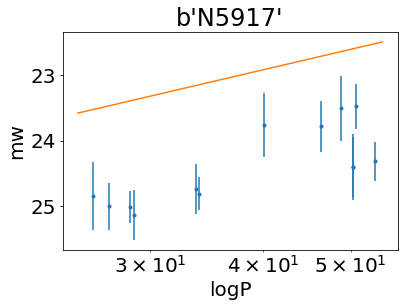

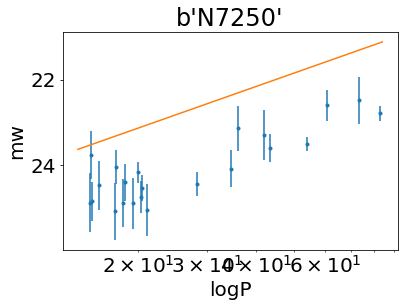

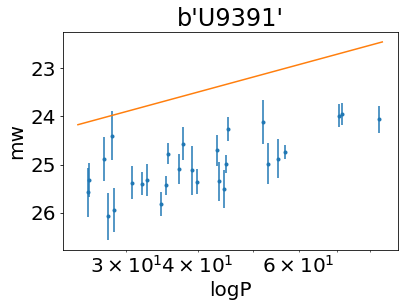

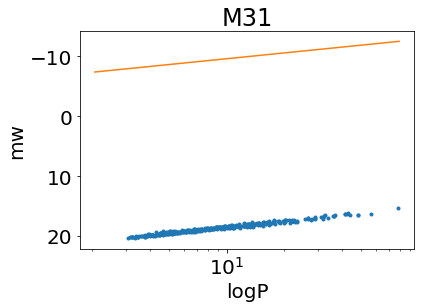

In [74]:
mu_mu4258_fit = res[:n_sn]
zp = res[-5]
bw = res[-4]
zw = res[-2]
for host,i in zip(sn_host,np.arange(len(sn_host))):
    cephe_list = data_cephe[data_cephe['Field'] == host]
    plt.figure()
    plt.title(host)
    plt.errorbar(cephe_list['Per'], cephe_list['F160W']-R*cephe_list['F555W-F814W'],yerr=cephe_list['sigma_tot'],fmt='.')
    p = np.linspace(np.min(cephe_list['Per'])-1,np.max(cephe_list['Per'])+1,1000)
    plt.plot(p,mu_mu4258_fit[i]+zp+bw*np.log10(p)+zw*(np.mean(cephe_list['[O/H]'])))
    plt.gca().invert_yaxis()
    plt.xscale('log')
    plt.xlabel('logP')
    plt.ylabel('mw')
cephe_list = data_cephe[data_cephe['Field'] == b'M31']
plt.figure()
plt.title('M31')
plt.errorbar(cephe_list['Per'], cephe_list['F160W']-R*cephe_list['F555W-F814W'],yerr=cephe_list['sigma_tot'],fmt='.')
p = np.linspace(np.min(cephe_list['Per'])-1,np.max(cephe_list['Per'])+1,1000)
plt.plot(p,res[-6]+bw*np.log10(p)+zw*(np.mean(cephe_list['[O/H]'])))
plt.gca().invert_yaxis()
plt.xscale('log')
plt.xlabel('logP')
plt.ylabel('mw')
plt.show()

## Fit with 3 anchors - Work in progress

In [ ]:
#res = mu_i, Delta_mu4258, MW_H, Delta_muLMC, mu_M31, bw, bl, MB0, Zw, Delta_zp
n_params = 10

########################
#Ceph and SN in SN HOST#
########################

n_ceph_by_host = [len(data_cephe[data_cephe['Field']== host]) for host in sn_host]
n_ceph = np.sum(n_ceph_by_host)
n_ceph_cumsum = np.concatenate(([0],np.cumsum(n_ceph_by_host)))
n_sn = len(sn_host)
L_ceph = np.zeros((n_ceph,n_sn+n_params))
L_sn = np.zeros((n_sn,n_sn+n_params))
y_ceph=np.zeros(n_ceph)
y_sn = np.zeros(n_sn)
cov_ceph=np.zeros(n_ceph)
cov_sn=np.zeros(n_sn)

for i,host in enumerate(sn_host):
    selec_ceph = data_cephe[data_cephe['Field'] == host]
    P_sup10 = selec_ceph['Per'] > 10
    P_inf10 = [not bool for bool in P_sup10]
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],i] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-8] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-5] = np.log10(selec_ceph['Per'])*P_sup10
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-4] = np.log10(selec_ceph['Per'])*P_inf10
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-2] = selec_ceph['[O/H]'] 
 
    L_sn[i,i] = 1
    L_sn[i,-3] = 1
    
    y_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
    y_sn[i] = data_sn[data_sn['Field'] == host]['mag_5a'] - 5*av
    
    cov_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = pw(selec_ceph['sigma_tot'],2)
    cov_sn[i] = pw(data_sn[data_sn['Field'] == host]['sigma_mag_5a'],2)-25*pw(sigma_av,2)
    
y_4258 = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
cov_4258 = pw(selec_ceph['sigma_tot'],2)


In [ ]:
##################
#Ceph in NGC 4258#
##################

selec_ceph = data_cephe[data_cephe['Field']== b'N4258']
n_4258 = len(selec_ceph)
L_4258 = np.zeros((n_4258,n_sn+n_params))
P_sup10 = selec_ceph['Per'] > 10
P_inf10 = [not bool for bool in P_sup10]
L_4258[:,-9] = 1
L_4258[:,-5] = np.log10(selec_ceph['Per'])*P_sup10
L_4258[:,-4] = np.log10(selec_ceph['Per'])*P_inf10
L_4258[:,-1] = selec_ceph['[O/H]'] 

y_4258 = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']-mu_N4258
cov_4258 = pw(selec_ceph['sigma_tot'],2)+pw(sigma_mu_N4258,2)

In [ ]:
#############
#Ceph in M31#
#############

selec_ceph = data_cephe[data_cephe['Field']== b'M31']
n_M31 = len(selec_ceph)
L_M31 = np.zeros((n_M31,n_sn+n_params))
P_sup10 = selec_ceph['Per'] > 10
P_inf10 = [not bool for bool in P_sup10]
L_M31[:,-6] = 1
L_M31[:,-8] = 1
L_M31[:,-5] = np.log10(selec_ceph['Per'])*P_sup10
L_M31[:,-4] = np.log10(selec_ceph['Per'])*P_inf10
L_M31[:,-2] = selec_ceph['[O/H]'] 

y_M31 = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
cov_M31 = pw(selec_ceph['sigma_tot'],2)


L = np.concatenate((L_ceph,L_sn),axis=0)
y = np.concatenate((y_ceph,y_sn))
C = np.diag(np.concatenate((cov_ceph,cov_sn)))

In [ ]:
############
#Ceph in MW#
############

selec_ceph = data_cephe[data_cephe['Field']== b'MW']
n_MW = len(selec_ceph)
L_MW = np.zeros((n_MW,n_sn+n_params))
P_sup10 = selec_ceph['Per'] > 10
P_inf10 = [not bool for bool in P_sup10]
L_MW[:,-6] = 1
L_MW[:,-8] = 1
L_MW[:,-5] = np.log10(selec_ceph['Per'])*P_sup10
L_MW[:,-4] = np.log10(selec_ceph['Per'])*P_inf10
L_MW[:,-2] = selec_ceph['[O/H]'] 

y_MW = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
cov_MW = pw(selec_ceph['sigma_tot'],2)
